### Notebook to format _Yoshida 2022_ and Healthy bronchial epithelial cells (BrEpit) for label transfer with `scnym`

- **Developed by**: Anna Maguza
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- 25th November 2022

#### Import required modules

In [1]:
import scnym

In [2]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

#### Setup Cells

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi = 160, color_map = 'magma_r', dpi_save = 300, vector_friendly = True)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.22.2.post1 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.7.0 leidenalg==0.8.0


#### Read reference object

In [5]:
input_Normal_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Raw_data/Normal Control Gut Cell Atlas/Full_obj_raw_counts_nosoupx_v2.h5ad'  # the file that will store the analysis results
output_Normal_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Gut_cell_atlas_three_donors_output.h5ad'  # the file that will store the analysis results

In [6]:
#Anndata upload
control_ad = sc.read_h5ad(input_Normal_file)
control_ad.X

<428469x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 760344941 stored elements in Compressed Sparse Row format>

#### Quick Filtering of Gut Cell Atlas file

In [7]:
#Remove Pediatric Crohn Disease
control_ad_clean = control_ad[~control_ad.obs['Diagnosis'].isin(['Pediatric Crohn Disease']),:]
del control_ad
#Deleting the lymph node samples
control_ad_clean = control_ad_clean[~control_ad_clean.obs['Region'].isin(['lymph node']),:]
#Adding percentage of ribosomial genes
control_ad_clean.var['ribo'] = control_ad_clean.var_names.str.startswith(("RPS","RPL"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(control_ad_clean, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
#Filtering by genes
control_ad_clean = control_ad_clean[control_ad_clean.obs.n_genes_by_counts < 5000, :]
control_ad_clean = control_ad_clean[control_ad_clean.obs.n_genes_by_counts > 200, :]
#Filtering by counts
control_ad_clean = control_ad_clean[control_ad_clean.obs.total_counts < 50000, :]
# Chose three adult donors for further analysis
three_donors = control_ad_clean[control_ad_clean.obs['Sample name'].isin(['A33 (414C)', 'A34 (417C)', 'A32 (411C)']), :]
del control_ad_clean

Trying to set attribute `.var` of view, copying.


#### Read in query

In [8]:
input_CRC_file = '/lustre/groups/talaveralopez/datasets/Colorectal_cancer/Raw_data/Joanito, 2022/Anndata Raw/joanito_2022_anndata_raw-2.h5ad'  # the file that will store the analysis results
output_CRC_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/joanito_2022_anndata_output.h5ad'  # the file that will store the analysis results

In [9]:
#Anndata upload
Joanito_ad = sc.read_h5ad(input_CRC_file)
Joanito_ad.X

<373058x33287 sparse matrix of type '<class 'numpy.float32'>'
	with 741331835 stored elements in Compressed Sparse Row format>

#### Quick Filtering of Joanito file

In [10]:
#Filter out normal (non-tumor samles)
Joanito_ad_tumor = Joanito_ad[Joanito_ad.obs['sample.origin'] == "Tumor", :]
del Joanito_ad

In [11]:
#Filtering by quality metrics
#Calculate quality control metrics
sc.pp.calculate_qc_metrics(Joanito_ad_tumor, expr_type = 'counts', var_type='genes', percent_top = None, inplace=True)
#Filtering by genes
Joanito_ad_tumor = Joanito_ad_tumor[Joanito_ad_tumor.obs.n_genes_by_counts < 4000, :]
Joanito_ad_tumor = Joanito_ad_tumor[Joanito_ad_tumor.obs.n_genes_by_counts > 200, :]
#Filtering by counts
Joanito_ad_tumor = Joanito_ad_tumor[Joanito_ad_tumor.obs.total_counts < 20000, :]

Trying to set attribute `.obs` of view, copying.


#### Format reference for `scNym`

In [12]:
three_donors

View of AnnData object with n_obs × n_vars = 83388 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
Joanito_ad_tumor

View of AnnData object with n_obs × n_vars = 150571 × 33287
    obs: 'cell.ID', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset_x', 'cell.type', 'iCMS', 'msi', 'dataset_y', 'Gender', 'Age at recruitment', 'MSS/MSI', 'Site', 'Sidedness', 'Group Stage', 'Stage TNM', 'iCMS.transcriptomic', 'iCMS.inferCNV', 'KRAS', 'BRAF', 'TP53', 'APC', 'PIK3CA', 'LymphNode', 'Normal', 'Tumor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [14]:
# Make cell.ID column in Joanito_ad_tumor the index
Joanito_ad_tumor.obs.index = Joanito_ad_tumor.obs['cell.ID']
# Delete cell.ID column in Joanito_ad_tumor
del Joanito_ad_tumor.obs['cell.ID']

In [14]:
Joanito_ad_tumor.obs["Study"] = "Joanito, 2022"
Joanito_ad_tumor.obs['Study'] = Joanito_ad_tumor.obs['Study'].astype('category')
three_donors.obs["Study"] = "Gut Cell Atlas"
three_donors.obs['Study'] = three_donors.obs['Study'].astype('category')
Joanito_ad_tumor.obs.rename(columns={"Age at recruitment": "Age"}, inplace=True)
Joanito_ad_tumor.obs.rename(columns={"percent.mt": "pct_counts_mt"}, inplace=True)
Joanito_ad_tumor.obs.rename(columns={"Site": "Region code"}, inplace=True)
Joanito_ad_tumor.obs['Region code'] = Joanito_ad_tumor.obs['Region code'].astype('category')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [15]:
Joanito_ad_tumor.obs['domain_label'] = Joanito_ad_tumor.obs['sample.ID'].copy()
Joanito_ad_tumor.obs['domain_label'] = 'target_' + Joanito_ad_tumor.obs['domain_label'].astype(str)
Joanito_ad_tumor.obs['domain_label'] = Joanito_ad_tumor.obs['domain_label'].astype('category')
Joanito_ad_tumor.obs['domain_label'].cat.categories

Index(['target_CRC-JSC-S02-GIS-N-US', 'target_CRC-JSC-S02-GIS-T-US-1',
       'target_CRC-JSC-S02-GIS-T-US-2', 'target_CRC-JSC-S03-GIS-N-US-1',
       'target_CRC-JSC-S03-GIS-N-US-2', 'target_CRC-JSC-S03-GIS-T-US-1',
       'target_CRC-JSC-S03-GIS-T-US-2', 'target_CRC-JSC-S04-GIS-T-US-1',
       'target_CRC-JSC-S04-GIS-T-US-2', 'target_CRC-JSC-S05-GIS-T-US-1',
       'target_CRC-JSC-S05-GIS-T-US-2', 'target_CRC-JSC-S06-GIS-T-US-1',
       'target_CRC-JSC-S06-GIS-T-US-2', 'target_CRC-JSC-S07-GIS-T-US-1',
       'target_CRC-JSC-S07-GIS-T-US-2', 'target_CRC-JSC-S08-GIS-T-US-1',
       'target_CRC-JSC-S08-GIS-T-US-2', 'target_CRC-JSC-S10-GIS-T-US-1',
       'target_CRC-JSC-S10-GIS-T-US-2', 'target_CRC-JSC-S12-GIS-T-US-1',
       'target_CRC-JSC-S12-GIS-T-US-2', 'target_CRC-JSC-S13-GIS-T-US-1',
       'target_CRC-JSC-S13-GIS-T-US-2', 'target_CRC-JSC-S14-GIS-T-US-1',
       'target_CRC-JSC-S14-GIS-T-US-2', 'target_CRC-JSC-S15-GIS-N-US-1',
       'target_CRC-JSC-S15-GIS-N-US-2', 'target_CRC-J

In [22]:
Joanito_ad_tumor.obs['cell_states'] = 'Unlabeled'
Joanito_ad_tumor.obs['cell_states'] = Joanito_ad_tumor.obs['cell_states'].astype('category')

In [16]:
Joanito_ad_tumor.obs

nFeature_RNA  pct_counts_mt sample.ID  \
cell.ID                                                                   
CRC16_MUX8563_AAAGATGCAGAAGCAC-1          4759      23.734351   MUX8563   
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1          2499      11.020450   MUX8563   
CRC16_MUX8563_ACATACGGTTACGTCA-1          3745      17.618134   MUX8563   
CRC16_MUX8563_ACATGGTGTCCATGAT-1          6874      17.782717   MUX8563   
CRC16_MUX8563_ACGAGGACATCTGGTA-1          5116      18.923530   MUX8563   
...                                        ...            ...       ...   
KUL5_EXT127_TTGGAACGTGAAAGAG-1            1144       8.299758    EXT127   
KUL5_EXT127_TTGGCAACATGGTAGG-1            1235       2.585657    EXT127   
KUL5_EXT127_TTTCCTCCATTACGAC-1             833       6.911582    EXT127   
KUL5_EXT127_TTTGCGCGTTCGTGAT-1            1472       4.568457    EXT127   
KUL5_EXT127_TTTGCGCTCATGGTCA-1            2668       1.475736    EXT127   

                                 patient.ID sample.origin dataset_x  \
cell.ID                                                               
CRC16_MUX8563_AAAGATGCAGAAGCAC-1    CRC2794         Tumor   CRC-SG1   
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1    CRC2794         Tumor   CRC-SG1   
CRC16_MUX8563_ACATACGGTTACGTCA-1    CRC2794         Tumor   CRC-SG1   
CRC16_MUX8563_ACATGGTGTCCATGAT-1    CRC2794         Tumor   CRC-SG1   
CRC16_MUX8563_ACGAGGACATCTGGTA-1    CRC2794         Tumor   CRC-SG1   
...                                     ...           ...       ...   
KUL5_EXT127_TTGGAACGTGAAAGAG-1        SC044         Tumor      KUL5   
KUL5_EXT127_TTGGCAACATGGTAGG-1        SC044         Tumor      KUL5   
KUL5_EXT127_TTTCCTCCATTACGAC-1        SC044         Tumor      KUL5   
KUL5_EXT127_TTTGCGCGTTCGTGAT-1        SC044         Tumor      KUL5   
KUL5_EXT127_TTTGCGCTCATGGTCA-1        SC044         Tumor      KUL5   

                                   cell.type   iCMS  msi dataset_y  ...  \
cell.ID                                                             ...   
CRC16_MUX8563_AAAGATGCAGAAGCAC-1  Epithelial  iCMS2  MSS   CRC-SG1  ...   
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1  Epithelial  iCMS2  MSS   CRC-SG1  ...   
CRC16_MUX8563_ACATACGGTTACGTCA-1  Epithelial  iCMS2  MSS   CRC-SG1  ...   
CRC16_MUX8563_ACATGGTGTCCATGAT-1  Epithelial  iCMS2  MSS   CRC-SG1  ...   
CRC16_MUX8563_ACGAGGACATCTGGTA-1  Epithelial  iCMS2  MSS   CRC-SG1  ...   
...                                      ...    ...  ...       ...  ...   
KUL5_EXT127_TTGGAACGTGAAAGAG-1          T_NK    nan  nan      KUL5  ...   
KUL5_EXT127_TTGGCAACATGGTAGG-1       PlasmaB    nan  nan      KUL5  ...   
KUL5_EXT127_TTTCCTCCATTACGAC-1          T_NK    nan  nan      KUL5  ...   
KUL5_EXT127_TTTGCGCGTTCGTGAT-1          T_NK    nan  nan      KUL5  ...   
KUL5_EXT127_TTTGCGCTCATGGTCA-1       PlasmaB    nan  nan      KUL5  ...   

                                 PIK3CA  LymphNode Normal Tumor  \
cell.ID                                                           
CRC16_MUX8563_AAAGATGCAGAAGCAC-1     wt        0.0    1.0   4.0   
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1     wt        0.0    1.0   4.0   
CRC16_MUX8563_ACATACGGTTACGTCA-1     wt        0.0    1.0   4.0   
CRC16_MUX8563_ACATGGTGTCCATGAT-1     wt        0.0    1.0   4.0   
CRC16_MUX8563_ACGAGGACATCTGGTA-1     wt        0.0    1.0   4.0   
...                                 ...        ...    ...   ...   
KUL5_EXT127_TTGGAACGTGAAAGAG-1      nan        0.0    2.0   3.0   
KUL5_EXT127_TTGGCAACATGGTAGG-1      nan        0.0    2.0   3.0   
KUL5_EXT127_TTTCCTCCATTACGAC-1      nan        0.0    2.0   3.0   
KUL5_EXT127_TTTGCGCGTTCGTGAT-1      nan        0.0    2.0   3.0   
KUL5_EXT127_TTTGCGCTCATGGTCA-1      nan        0.0    2.0   3.0   

                                 n_genes_by_counts log1p_n_genes_by_counts  \
cell.ID                                                                      
CRC16_MUX8563_AAAGATGCAGAAGCAC-1              1531                7.334329   
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1              1686  

#### Format reference for `scNym`

In [18]:
three_donors.obs['cell_states'] = three_donors.obs['category'].copy()
three_donors.obs['cell_states'] = three_donors.obs['cell_states'].astype('category')

In [21]:
three_donors.obs['domain_label'] = three_donors.obs['sample name'].copy()
three_donors.obs['domain_label'] = 'train_' + three_donors.obs['domain_label'].astype(str)
three_donors.obs['domain_label'] = three_donors.obs['domain_label'].astype('category')
three_donors.obs['domain_label'].cat.categories

Index(['train_A32-APD-0-SC-45N-1', 'train_A32-APD-0-SC-45P-1',
       'train_A32-CAE-0-SC-45N-1', 'train_A32-CAE-0-SC-45P-1',
       'train_A32-ILE-1-SC-45N-1', 'train_A32-ILE-1-SC-45P-1',
       'train_A32-ILE-2-SC-45N-1', 'train_A32-ILE-2-SC-45P-1',
       'train_A32-SCL-0-SC-45N-1', 'train_A32-SCL-0-SC-45P-1',
       'train_A32-TCL-0-SC-45N-1', 'train_A32-TCL-0-SC-45P-1',
       'train_A33-ACL-0-SC-45P-1', 'train_A33-APD-0-SC-45P-1',
       'train_A33-CAE-0-SC-45N-1', 'train_A33-CAE-0-SC-45P-1',
       'train_A33-ILE-1-SC-45P-1', 'train_A33-ILE-2-SC-45P-1',
       'train_A33-JEJ-0-SC-45P-1', 'train_A33-REC-0-SC-45N-1',
       'train_A33-REC-0-SC-45P-1 ', 'train_A33-SCL-0-SC-45N-1',
       'train_A33-TCL-0-SC-45N-1', 'train_A33-TCL-0-SC-45P-1',
       'train_A34-ACL-1-SC-45N-1', 'train_A34-ACL-1-SC-45P-1',
       'train_A34-APD-1-SC-45N-1', 'train_A34-APD-1-SC-45P-1',
       'train_A34-CAE-1-SC-45N-1', 'train_A34-CAE-1-SC-45P-1',
       'train_A34-DCL-1-SC-45N-1', 'train_A34-DCL-1-SC

#### Merge two objects 

In [24]:
REF_QUERY = Joanito_ad_tumor.concatenate(three_donors, batch_key = 'object', batch_categories = ['query', 'reference'], join = 'inner')
REF_QUERY

AnnData object with n_obs × n_vars = 233959 × 33264
    obs: 'nFeature_RNA', 'pct_counts_mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset_x', 'cell.type', 'iCMS', 'msi', 'dataset_y', 'Gender', 'Age', 'MSS/MSI', 'Region code', 'Sidedness', 'Group Stage', 'Stage TNM', 'iCMS.transcriptomic', 'iCMS.inferCNV', 'KRAS', 'BRAF', 'TP53', 'APC', 'PIK3CA', 'LymphNode', 'Normal', 'Tumor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Study', 'domain_label', 'cell_states', 'Sample name', 'Diagnosis', 'sample name', 'Fraction', 'Region', '10X', 'batch', 'n_genes', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'total_counts_ribo', 'pct_counts_ribo', 'object'
    var: 'feature_types', 'genome-query', 'n_cells_by_counts-query', 'mean_counts-query', 'log1p_mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'log1p_total_counts-query', 'n_cells_by_counts-reference', 'mean_counts-r

#### Clean up object

- Clean up `adata.obs`

In [31]:
REF_QUERY.obs.drop(REF_QUERY.obs.columns.difference(['domain_label','cell_states', 'object']), 1, inplace = True)
REF_QUERY

AnnData object with n_obs × n_vars = 233959 × 33264
    obs: 'domain_label', 'cell_states', 'object'
    var: 'feature_types', 'genome-query', 'n_cells_by_counts-query', 'mean_counts-query', 'log1p_mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'log1p_total_counts-query', 'n_cells_by_counts-reference', 'mean_counts-reference', 'pct_dropout_by_counts-reference', 'total_counts-reference', 'gene_ids-reference', 'ribo-reference'

- Clean up `adata.var`

In [32]:
REF_QUERY.var.drop(REF_QUERY.var.columns.difference(['mt']), 1, inplace = True)
REF_QUERY

AnnData object with n_obs × n_vars = 233959 × 33264
    obs: 'domain_label', 'cell_states', 'object'

In [33]:
del Joanito_ad_tumor, three_donors

#### LogP1 normalization

In [35]:
#Log normalization
sc.pp.log1p(REF_QUERY)

#### Train reference with `scNym`

In [37]:
scnym.api.scnym_api(
    adata = REF_QUERY,
    task = 'train',
    groupby = 'cell_states',
    domain_groupby='domain_label',
    out_path = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/',
    config = 'new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

150571 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (83388, 33264)
target   examples:  (150571, 33264)
X:  (83388, 33264)
y:  (83388,)
Using user provided domain labels.
Found 47 source domains and 97 target domains.
Not weighting classes and not balancing classes.
Found 144 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has 

In [44]:
scnym.api.scnym_api(
    adata=REF_QUERY,
    task='predict',
    key_added='scNym',
    trained_model='./scnym_output',
    out_path='./scnym_output',
    config='new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 8 classes from 33264 features
['B cells' 'Endothelial' 'Epithelial' 'Mesenchymal' 'Myeloid' 'Neuronal'
 'Plasma cells' 'T cells']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|█████████████████████| 229/229 [00:47<00:00,  4.87it/s]


Extracting model embeddings...


In [48]:
REF_QUERY.obs['scNym'].value_counts()

Epithelial      221805
Plasma cells     12154
Name: scNym, dtype: int64

In [49]:
sc.pp.neighbors(REF_QUERY, use_rep = 'X_scnym', n_neighbors = 50)
sc.tl.umap(REF_QUERY, min_dist = 0.2, spread = 5, random_state = 1712)

computing neighbors


/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/numba/core/typed_passes.py:313: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:10)
computing UMAP


/home/icb/anna.maguza/miniconda3/envs/scnym_env/lib/python3.8/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:08:22)


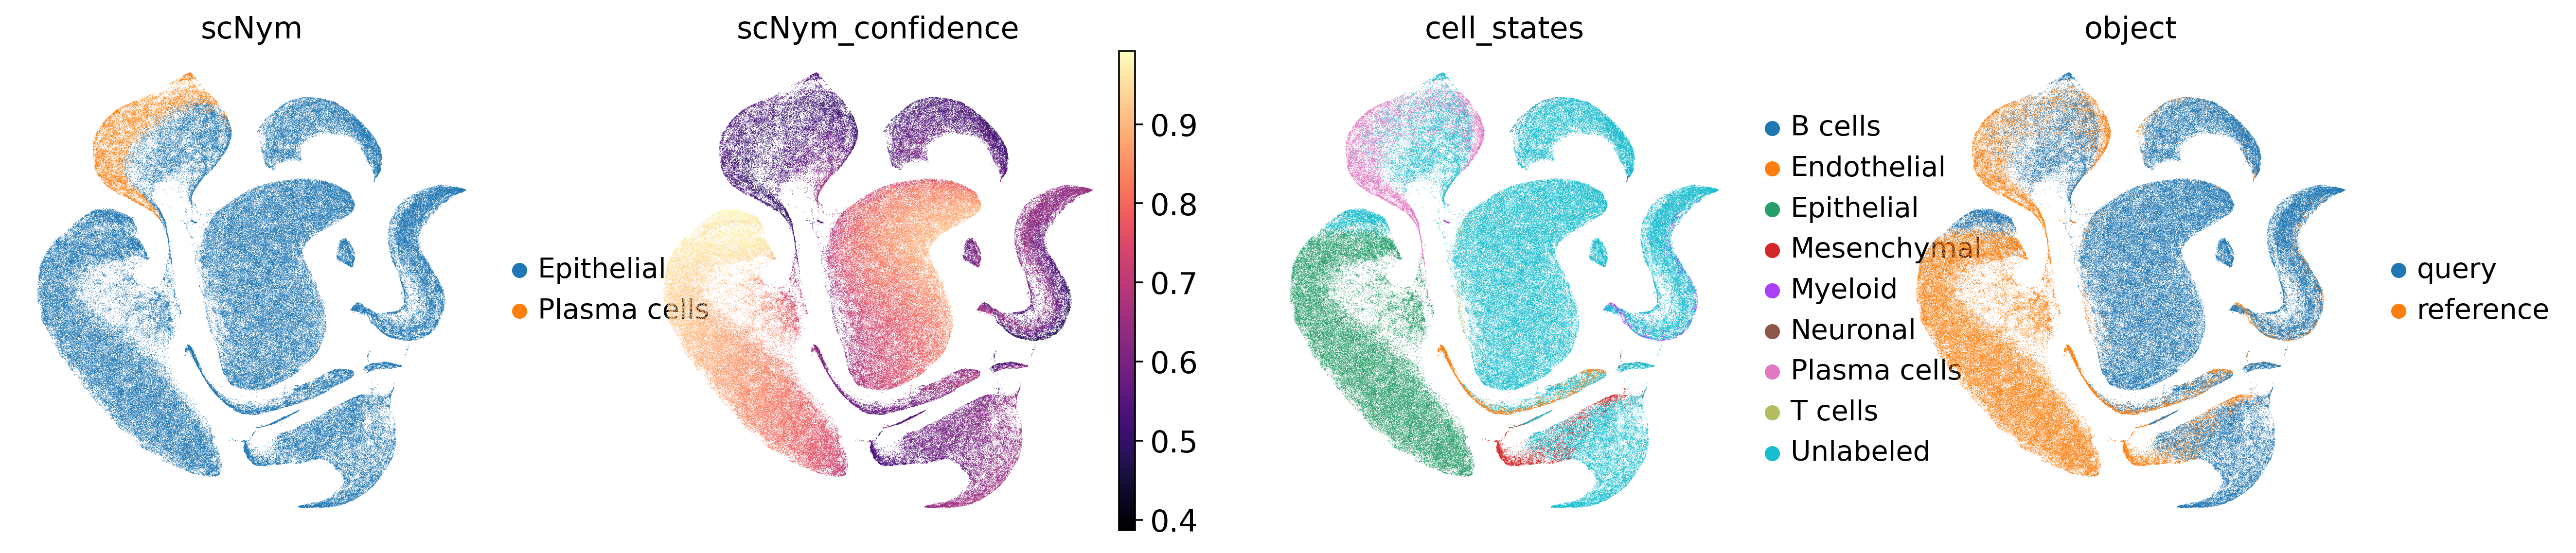

In [51]:
sc.pl.umap(REF_QUERY, color=['scNym', 'scNym_confidence','cell_states', 'object'], color_map = "magma", size = 0.3, frameon = False)

#### Save the object

In [45]:
adata_export = anndata.AnnData(X = REF_QUERY.X, obs = REF_QUERY.obs, var = REF_QUERY.var, uns = REF_QUERY.uns, obsm = REF_QUERY.obsm, obsp = REF_QUERY.obsp)
adata_export

AnnData object with n_obs × n_vars = 233959 × 33264
    obs: 'domain_label', 'cell_states', 'object', 'scNym', 'scNym_confidence'
    uns: 'log1p', 'scNym_train_results', 'scNym_probabilities'
    obsm: 'X_scnym'

In [46]:
adata_export.write('/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/Post_scnym_Joanito_three_donors_trained.h5ad')

... storing 'domain_label' as categorical
... storing 'cell_states' as categorical
... storing 'scNym' as categorical
